Importing required libraries and the dataset

To Do:
	Look at realtionship between small fires (<= 100m^2) and large fires, see if there are any correlations.
	See if the most impactful variable is the same for both
	See correlation


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statsmodels.api as sma
from sklearn.metrics import mean_squared_error



### Data Cleanup:

##### Convert month and day to numerical
##### Only take area values > 0


In [9]:
df = pd.read_csv('./forestfires.csv')
df.info()

# Change the month and day to integers
month_dict = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
              'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}

df.replace({'month': month_dict}, inplace=True)

day_dict = {'sun': 1, 'mon': 2, 'tue': 3,
            'wed': 4, 'thu': 5, 'fri': 6, 'sat': 7}

df.replace({'day':day_dict}, inplace=True)

df = df[df['area'] > 0]

#Convert area to log values
df['area'] = [np.log(area + 1) for area in df['area']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [543]:
# Correlation matrix that sorts high to low based on relationship to area
# Temperature and DMC have the highest correlation
# RH and rain are the only two variables with a negative correlation
df.corr().iloc[-1].sort_values(ascending=False)


area     1.000000
temp     0.097844
DMC      0.072994
X        0.063385
month    0.056496
DC       0.049383
day      0.048359
Y        0.044873
FFMC     0.040122
wind     0.012317
ISI      0.008258
rain    -0.007366
RH      -0.075519
Name: area, dtype: float64

[0.00335825]


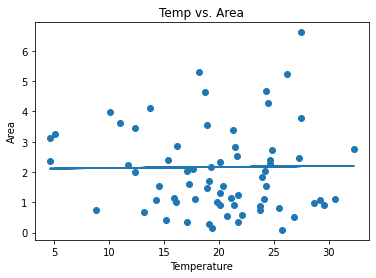

In [4]:
X = df[['temp']]
y = df['area']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

ols = LinearRegression().fit(X_train, y_train)
y_pred = ols.predict(X_test)

plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred)
plt.title('Temp vs. Area')
plt.xlabel('Temperature')
plt.ylabel('Area')
print(ols.coef_)


[-0.00418577]


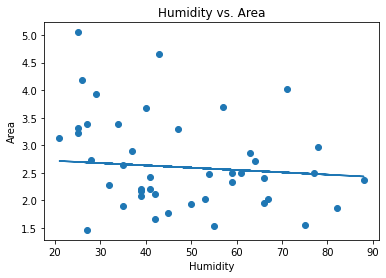

In [504]:
X = df[['RH']]
y = df['area']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

ols = LinearRegression().fit(X_train, y_train)
y_pred = ols.predict(X_test)

plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred)
plt.title('Humidity vs. Area')
plt.xlabel('Humidity')
plt.ylabel('Area')
print(ols.coef_)
plt.show()

[0.04117384]


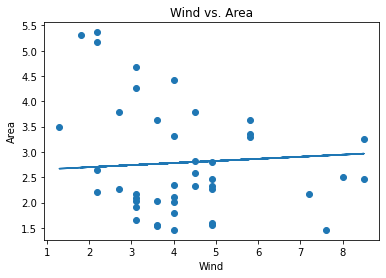

In [506]:
X = df[['wind']]
y = df['area']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

ols = LinearRegression().fit(X_train, y_train)
y_pred = ols.predict(X_test)

plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred)
plt.title('Wind vs. Area')
plt.xlabel('Wind')
plt.ylabel('Area')
print(ols.coef_)

<AxesSubplot:>

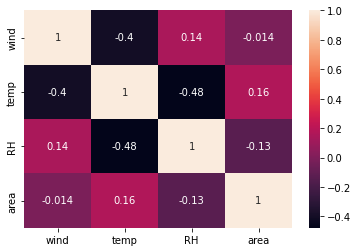

In [550]:
d = df[['wind','temp','RH','area']].corr()
sns.heatmap(d, annot = True)


                                 OLS Regression Results                                
Dep. Variable:                   area   R-squared (uncentered):                   0.728
Model:                            OLS   Adj. R-squared (uncentered):              0.724
Method:                 Least Squares   F-statistic:                              177.6
Date:                Tue, 06 Dec 2022   Prob (F-statistic):                    5.14e-56
Time:                        12:29:10   Log-Likelihood:                         -342.58
No. Observations:                 202   AIC:                                      691.2
Df Residuals:                     199   BIC:                                      701.1
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

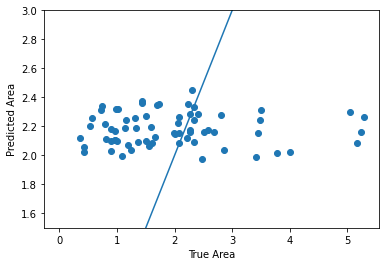

In [10]:
X = df[['wind', 'RH','temp']]
y = df['area']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

s_ols = sma.OLS(y_train, X_train).fit()
ols = LinearRegression().fit(X_train, y_train)
y_pred = ols.predict(X_test)

plt.scatter(y_test, y_pred)
plt.plot([0,5],[0,5])
plt.ylim([1.5,3])
plt.xlabel('True Area')
plt.ylabel('Predicted Area')
print(s_ols.summary())
